<center><h1> Fitting a Single Frame.

Let's crawl before we run. Here will generate a hologram with Lorenz-Mie theory and then fit said hologram to, you guessed it, the Lorenz-Mie theory. With any luck and/or scientific consistency, the fitting procedure will return the same parameters we used to generate the hologram.

In [1]:
# The Usual Suspects.
import numpy as np 
import scipy as sp    
import pandas as pd   
import os

In [50]:
# For our particular case.
import trackpy as tp      
from lorenzmie.theory import spheredhm
from lorenzmie.fitting.mie_fit import Mie_Fitter
from lmfit import report_fit

In [30]:
# For tracking.
from tracker import tracker

In [3]:
# For Plotting.
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=2)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)

Populating the interactive namespace from numpy and matplotlib


In [35]:
def inflate(image):
    '''Makes a BW image into a RGB image.
    '''
    shape = image.shape
    new_image = np.zeros([shape[0], shape[1], 3])
    new_image[:,:,0] = image
    new_image[:,:,1] = image
    new_image[:,:,2] = image
    return new_image

## Producing a frame.

In [23]:
# Parameter choices.
a_p = 0.5 # [um]
n_p = 1.5 # [1]
z_p = 120  # [pixel]
n_m = 1.339 # [1] - Refractive index of water.
lamb = 0.447 # [um] - Wavelength of blue laser.
dim = [640, 480] # [pixel, pixel] # Size of image.
mpp = 0.135 # [um/pixel] - Size of pixel after magnification.

In [27]:
image = spheredhm.spheredhm([100,75,z_p], a_p, n_p, n_m, lamb=lamb, dim=dim, mpp=mpp)

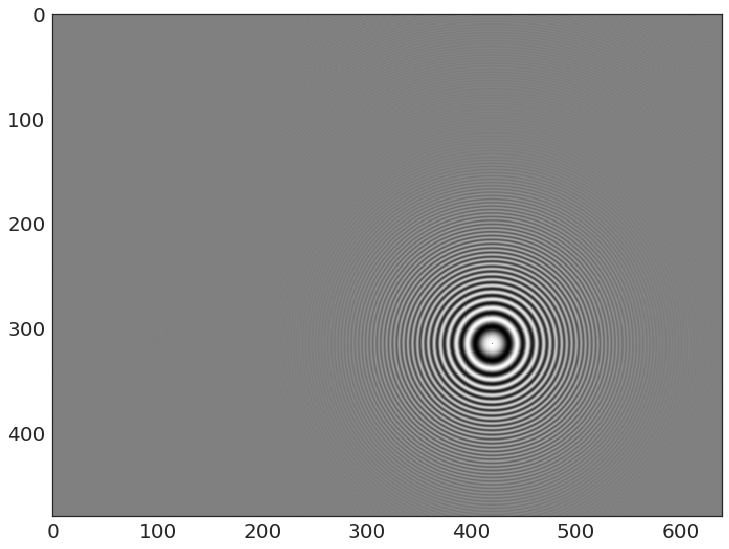

In [28]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(image, cmap='gray', interpolation=None)

## Find the holographic feature.

In [31]:
model = 'lmm_5_50k'
trk = tracker.tracker(model=model) # Instanciate tracker.

INFO:tensorflow:Restoring parameters from /home/mark/Github/tracker/models/lmm_5_50k.ckpt


In [38]:
feature = trk.predict(inflate(image*100))

## Fit the frame.
1. Find the feature in the image.
2. Crop to the relevant region.
3. Use mie_fit to fit the image.

In [54]:
# Crop the frame to a reasonable size for fitting.
xc, yc, w, h = feature[0]
cropped_image = image[yc-h/2:yc+h/2, xc-w/2:xc+w/2]
cropped_image = cropped_image[1:-1,:]

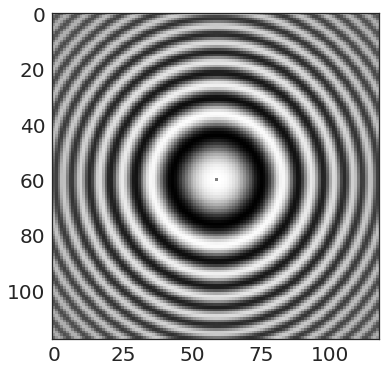

In [56]:
# Check the crop.
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(cropped_image, cmap='gray', interpolation=None)

In [85]:
# Guess where the particle is.
guesses = [0,     # x guess [pixel]
           0,     # y guess 
           120,   # z guess
           0.5,   # a_p [um]
           1.5,   # n_p [1]
           1.339,                    # n_m
           0.135,                    # mpp
           0.447]                    # lamb 

In [86]:
init_params = dict(zip(['x', 'y', 'z', 'a_p', 'n_p', 'n_m', 'mpp', 'lamb'], guesses))

In [87]:
mie_fit = Mie_Fitter(init_params)
result = mie_fit.fit(cropped_image)

In [88]:
# Fit the frame to the Lorenz-Mie Theory.
result.params

Parameters([('x',
             <Parameter 'x', value=2.5819395358161084e-08 +/- 0, bounds=[-inf:inf]>),
            ('y',
             <Parameter 'y', value=1.0000089311780223 +/- 0, bounds=[-inf:inf]>),
            ('z',
             <Parameter 'z', value=120.00172769765742 +/- 0, bounds=[-inf:inf]>),
            ('a_p',
             <Parameter 'a_p', value=0.49952294502322292 +/- 0, bounds=[-inf:inf]>),
            ('n_p',
             <Parameter 'n_p', value=1.5003412370469464 +/- 0, bounds=[-inf:inf]>),
            ('n_m', <Parameter 'n_m', value=1.339 (fixed), bounds=[-inf:inf]>),
            ('mpp', <Parameter 'mpp', value=0.135 (fixed), bounds=[-inf:inf]>),
            ('lamb',
             <Parameter 'lamb', value=0.447 (fixed), bounds=[-inf:inf]>)])

## Show the result side-by-side.

In [98]:
x, y, z, a_p, n_p, n_m, mpp, lamb = result.params.valuesdict().values()

In [100]:
fitted_image = spheredhm.spheredhm([x,y,z], a_p, n_p, n_m, lamb=lamb, dim=cropped_image.shape, mpp=mpp)

In [101]:
residual = result.residual.reshape(*cropped_image.shape)

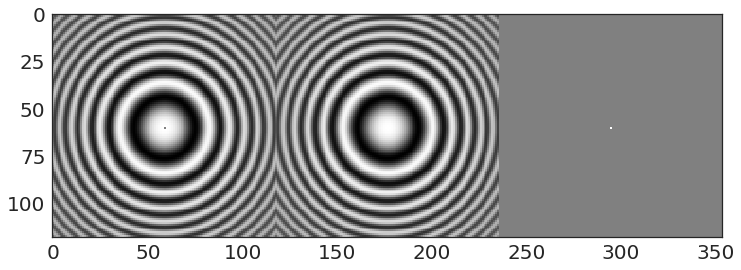

In [106]:
mega_image = np.hstack([cropped_image, fitted_image, residual+1.0])
fig, ax = plt.subplots(figsize=(12, 36))
ax.imshow(mega_image, cmap='gray', interpolation='none')